In [1]:
import os
import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import medfilt
from scipy import interpolate, signal

In [2]:
# Directories and files
data_dir = os.path.join(os.environ.get('HOME'), 'data')
xl_files = glob.glob(os.path.join(data_dir, '*.xlsx'))
print(xl_files)

# Load the Excel files
df_list = []
for file in xl_files:
    signal_name = os.path.splitext(os.path.basename(file))[0].lower().split('_')[0]
    df_file = pd.read_excel(file, index_col=None)
    df_file.columns=['index', 'time', signal_name]
    df_list.append(df_file)
df = pd.concat(df_list, axis=1, join='inner').\
                drop('index', axis=1)
df = df.loc[:,~df.columns.duplicated()].copy()
display(df.head())

['/home/andreas/data/Noise_Signal.xlsx', '/home/andreas/data/Clear_Signal.xlsx']


,time,noise,clear
0,0.000000,22.908078,7.786733
1,0.011111,22.899937,7.801260
2,0.022222,22.891796,7.815788
3,0.033333,22.883655,7.830316
4,0.044444,22.878556,7.821183


In [3]:
# Select the signal and time column
time_col = 'time'
sig_col_list = ['noise', 'clear']
sig_col = sig_col_list[1]

sig = df[sig_col].values
time = df[time_col].values

# Calculate the scan rate
timeIncrement = np.mean(np.diff(time))
rate = 1/timeIncrement

# Apply filters
windowms=(400, 1200)
kernel_size_1 = (int(np.floor(windowms[0] / 1000 / timeIncrement / 2)) * 2) + 1
kernel_size_2 = (int(np.floor(windowms[1] / 1000 / timeIncrement / 2)) * 2) + 1

# Baseline wander signal: cascade of 2 median filters
medfilt1 = medfilt(sig, kernel_size=kernel_size_1)
medfilt2 = medfilt(medfilt1, kernel_size=kernel_size_2)

# Corrected signal
sig_cor = sig - medfilt2

37
107


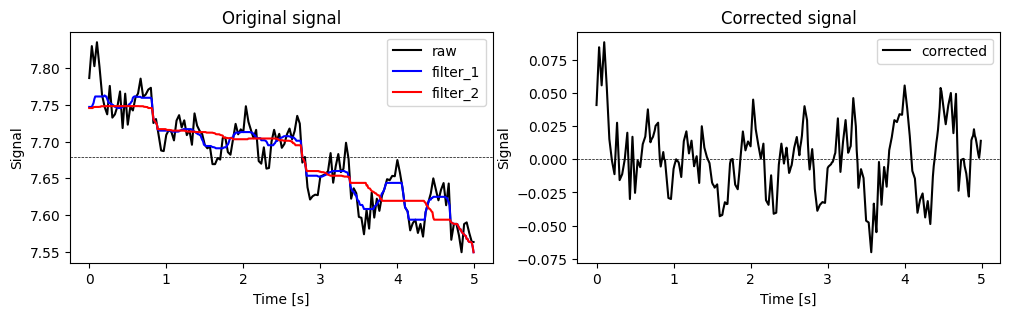

In [4]:
print(kernel_size_1)
print(kernel_size_2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
ax[0].plot(time, sig, color='k', label='raw')
ax[0].plot(time, medfilt1, color='b', label='filter_1')
ax[0].plot(time, medfilt2, color='r', label='filter_2')
ax[0].axhline(y=float(np.mean(sig)), color='k', linestyle='--', linewidth=0.5)
ax[0].set(title='Original signal')
ax[1].plot(time, sig_cor, 'k', label='corrected')
ax[1].axhline(y=0, color='k', linestyle='--', linewidth=0.5)
ax[1].set(title='Corrected signal')
for a, axa in enumerate(ax):
    axa.set(xlabel='Time [s]', ylabel='Signal')
    axa.legend()
plt.show()

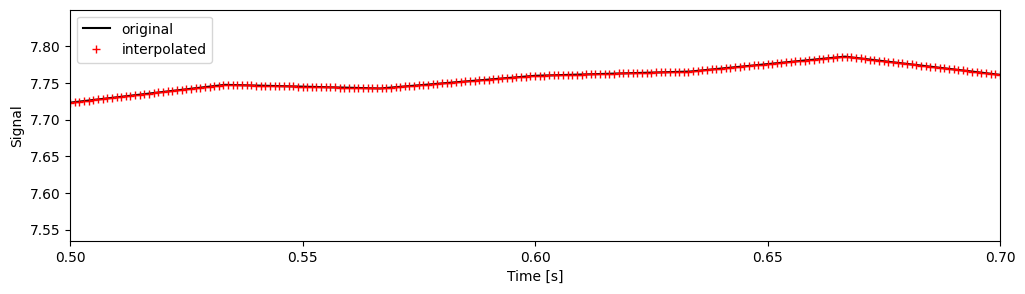

In [5]:
# Interpolate the signal
rate_interp = 1000
def interpolate_signal(sig, rate, rate_interp):
    time = np.arange(len(sig))/rate
    time_interp = np.arange(time[0], time[-1], 1/rate_interp)
    func = interpolate.interp1d(x=time, y=sig, kind='linear')
    return func(time_interp)

# Let's see how this works
time = np.arange(len(sig))/rate
time_interp = np.arange(time[0], time[-1], 1/rate_interp)
sig_interp = interpolate_signal(sig=sig, rate=rate, rate_interp=rate_interp)

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(time, sig, color='k', label='original')
ax.plot(time_interp, sig_interp, 'r+', label='interpolated')
ax.set(xlim=[0.50, 0.70], xticks=np.arange(0.50, 0.75, 0.05),
       xlabel='Time [s]', ylabel='Signal')
ax.legend()
plt.show()

In [6]:
# Normalize the data
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [7]:
overlapfrac = 0.5
window_size_s = 4
nperseg = int(np.around(window_size_s * rate_interp))
noverlap = int(np.around(overlapfrac * nperseg))
print(nperseg)
print(noverlap)

4000
2000


In [8]:
# PSD for all signals
# uncorrected signal no interpolation
f_sig, Pxx_sig = signal.welch(sig, rate)
Pxx_sig = NormalizeData(Pxx_sig)
f_sig_bpm = f_sig*60

# uncorrected signal with interpolation
sig_interp = interpolate_signal(sig=sig, rate=rate, rate_interp=rate_interp)
f_sig_interp, Pxx_sig_interp = signal.welch(x=sig_interp, 
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            scaling='density',
                                            fs=rate_interp)
Pxx_sig_interp = NormalizeData(Pxx_sig_interp)
f_sig_interp_bpm = f_sig_interp*60

# corrected signal no interpolation
f_cor, Pxx_cor = signal.welch(sig_cor, rate)
Pxx_cor = NormalizeData(Pxx_cor)
f_cor_bpm = f_cor*60

# corrected signal with interpolation
sig_cor_interp = interpolate_signal(sig=sig_cor, rate=rate, rate_interp=rate_interp)
f_cor_interp, Pxx_cor_interp = signal.welch(x=sig_cor_interp, 
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            scaling='density',
                                            fs=rate_interp)
Pxx_cor_interp = NormalizeData(Pxx_cor_interp)
f_cor_interp_bpm = f_cor_interp*60

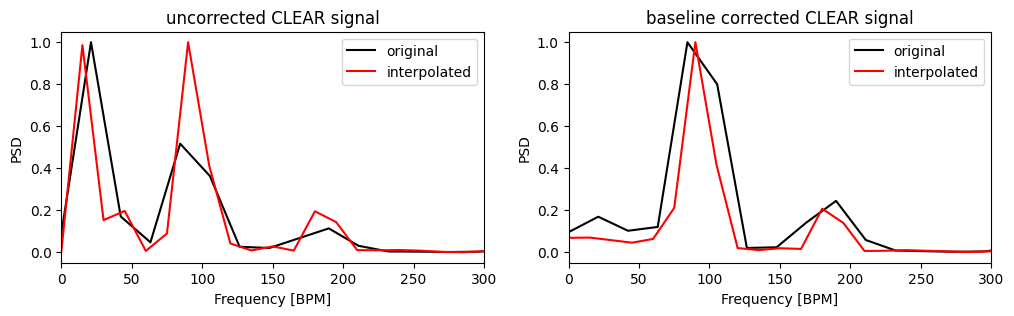

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
ax[0].plot(f_sig_bpm, Pxx_sig, 'k', label='original')
ax[0].plot(f_sig_interp_bpm, Pxx_sig_interp, 'r', label='interpolated')

ax[1].plot(f_cor_bpm, Pxx_cor, 'k', label='original')
ax[1].plot(f_cor_interp_bpm, Pxx_cor_interp, 'r', label='interpolated')

title_list = [f'uncorrected {sig_col.upper()} signal', 
              f'baseline corrected {sig_col.upper()} signal']
for a, axa in enumerate(ax):
    axa.set(xlim=[0, 300], xticks=np.arange(0, 350, 50),
            xlabel='Frequency [BPM]', ylabel='PSD', title=title_list[a])
    axa.legend()
plt.show()

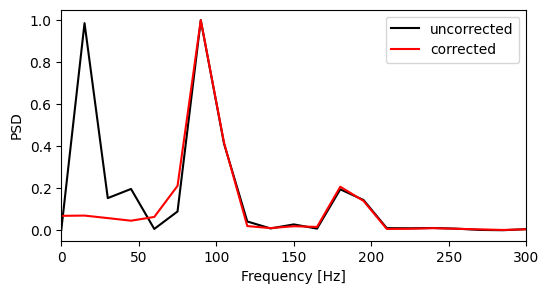

In [10]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(f_sig_interp_bpm, Pxx_sig_interp, 'k', label='uncorrected')
ax.plot(f_cor_interp_bpm, Pxx_cor_interp, 'r', label='corrected')
ax.set(xlim=[0, 300], xticks=np.arange(0, 350, 50), xlabel='Frequency [Hz]', ylabel='PSD')
ax.legend()
plt.show()

### Final processing function ###

In [11]:
# Putting it all together
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def interpolate_signal(sig, rate, rate_interp):
    time = np.arange(len(sig))/rate
    time_interp = np.arange(time[0], time[-1], 1/rate_interp)
    func = interpolate.interp1d(x=time, y=sig, kind='linear')
    return func(time_interp)

def correct_baseline(sig, rate, windowms=(400, 1200)):
        timeIncrement = 1/float(rate)
        kernel_size_1 = (int(np.floor(windowms[0] / 1000 / timeIncrement / 2)) * 2) + 1
        kernel_size_2 = (int(np.floor(windowms[1] / 1000 / timeIncrement / 2)) * 2) + 1
        # Baseline wander signal: cascade of 2 median filters
        medfilt1 = medfilt(sig, kernel_size=kernel_size_1)
        medfilt2 = medfilt(medfilt1, kernel_size=kernel_size_2)
        # Corrected signal
        sig_cor = sig - medfilt2
        return sig_cor

def get_psd(time, sig, rate_interp=1000):
    overlapfrac = 0.5
    window_size_s = 4
    nperseg = int(np.around(window_size_s * rate_interp))
    noverlap = int(np.around(overlapfrac * nperseg))
    timeIncrement = np.mean(np.diff(time))
    rate = 1/timeIncrement
    sig_cor = correct_baseline(sig=sig, rate=rate)
    sig_cor_interp = interpolate_signal(sig=sig_cor, rate=rate, rate_interp=rate_interp)
    f_cor_interp, Pxx_cor_interp = signal.welch(x=sig_cor_interp, 
                                                window='hann',
                                                nperseg=nperseg,
                                                noverlap=noverlap,
                                                scaling='density',
                                                fs=rate_interp)
    # Convert frequency into BPM and normalize y values
    frequencies = f_cor_interp*60
    power = NormalizeData(Pxx_cor_interp)
    
    return frequencies, power

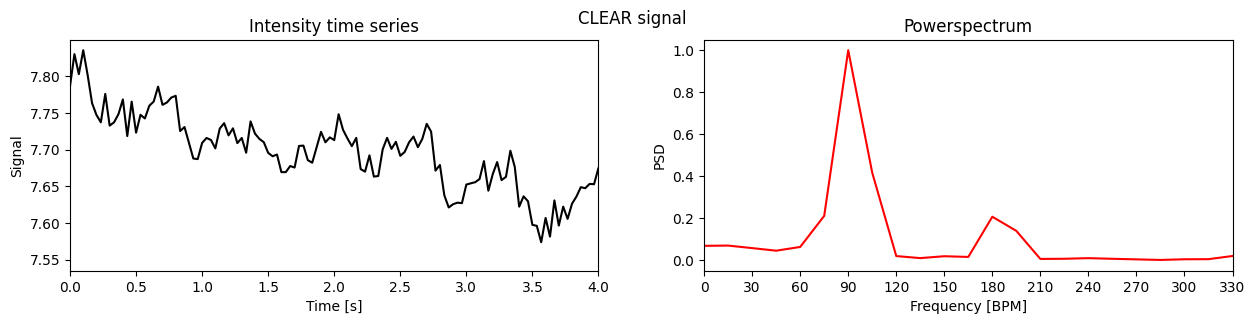

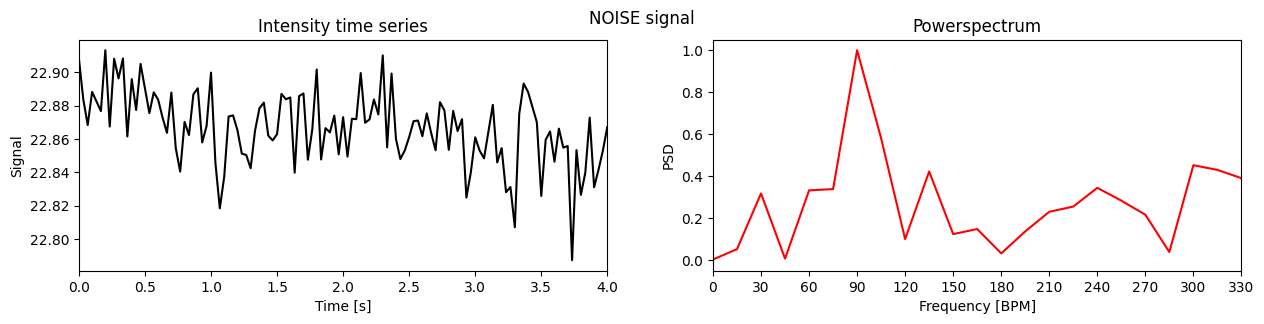

In [12]:
time = df[time_col].values
for sig_col in ['clear', 'noise']:
    sig = df[sig_col].values
    frequencies, power = get_psd(time=time, sig=sig)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
    ax[0].plot(time, sig, 'k')
    ax[0].set(xlim=[0, 4], xticks=np.arange(0, 4.2, 0.5), 
              xlabel='Time [s]', ylabel='Signal', title='Intensity time series')
    ax[1].plot(frequencies, power, 'r')
    ax[1].set(xlim=[0, 300], xticks=np.arange(0, 350, 30), 
              xlabel='Frequency [BPM]', ylabel='PSD', title='Powerspectrum')
    fig.suptitle(f'{sig_col.upper()} signal')
    plt.show()